<a href="https://colab.research.google.com/github/wel51x/DS-Unit-4-Sprint-4-Deep-Learning/blob/master/My_LS_DS_441_RNN_and_LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Recurrent Neural Networks and LSTM

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

# Lecture

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

## Time series with plain old regression

Recurrences are fancy, and we'll get to those later - let's start with something simple. Regression can handle time series just fine if you just set them up correctly - let's try some made-up stock data. And to make it, let's use a few list comprehensions!

####have to run this to get "RNN/LSTM Sentiment Classification with Keras" to work in colab

In [0]:
!pip install numpy==1.16.2
import numpy as np

  Using cached https://files.pythonhosted.org/packages/35/d5/4f8410ac303e690144f0a0603c4b8fd3b986feb2749c435f7cdbb288f17e/numpy-1.16.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.3
    Uninstalling numpy-1.16.3:
      Successfully uninstalled numpy-1.16.3


In [0]:
import numpy as np
from random import random
days = np.array((range(28)))
stock_quotes = np.array([random() + day * random() for day in days])

In [0]:
stock_quotes

array([ 0.93946324,  1.0571481 ,  1.51774439,  0.68658834,  2.74210724,
        5.03962965,  4.5159682 ,  6.12334082,  1.78574751,  2.60543214,
        5.11687757,  2.36898494,  0.99244726,  0.97977885,  8.59433569,
       12.92612961,  7.11021403,  8.37854738, 17.17967096, 14.79679294,
        6.57158313,  6.25892714,  8.02730179, 10.73601861,  7.81382042,
       10.14389937,  3.63117315, 12.95063727])

Let's take a look with a scatter plot:

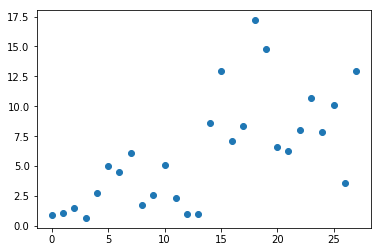

In [0]:
from matplotlib.pyplot import scatter
scatter(days, stock_quotes)

Looks pretty linear, let's try a simple OLS regression.

First, these need to be NumPy arrays:

In [0]:
days = days.reshape(-1, 1)  # X needs to be column vectors

Now let's use good old `scikit-learn` and linear regression:

In [0]:
from sklearn.linear_model import LinearRegression
ols_stocks = LinearRegression()
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.427895796633746

That seems to work pretty well, but real stocks don't work like this.

Let's make *slightly* more realistic data that depends on more than just time:

In [0]:
# Not everything is best as a comprehension
stock_data = np.empty([len(days), 4])
for day in days:
  asset = random()
  liability = random()
  quote = random() + ((day * random()) + (20 * asset) - (15 * liability))
  quote = max(quote, 0.01)  # Want positive quotes
  stock_data[day] = np.array([quote, day, asset, liability])

In [0]:
stock_data

array([[1.68263231e+01, 0.00000000e+00, 9.33922880e-01, 1.49770852e-01],
       [5.12474675e+00, 1.00000000e+00, 2.90165112e-01, 1.25936890e-01],
       [1.72852442e+01, 2.00000000e+00, 9.32212844e-01, 2.45917876e-01],
       [3.88379069e+00, 3.00000000e+00, 3.25414185e-01, 2.46151706e-01],
       [8.05891904e+00, 4.00000000e+00, 7.62633502e-01, 6.14639486e-01],
       [1.00000000e-02, 5.00000000e+00, 3.16884681e-01, 8.19569566e-01],
       [3.60595259e+00, 6.00000000e+00, 2.52832251e-01, 3.03603351e-01],
       [4.45217052e+00, 7.00000000e+00, 5.21362264e-01, 5.41791767e-01],
       [6.28466804e+00, 8.00000000e+00, 4.99645475e-01, 6.22925023e-01],
       [2.37840085e+01, 9.00000000e+00, 9.92414980e-01, 5.17673147e-02],
       [2.88670184e+00, 1.00000000e+01, 9.77291632e-02, 3.82768108e-01],
       [4.42172096e+00, 1.10000000e+01, 3.80999803e-01, 6.99962341e-01],
       [1.94599326e+01, 1.20000000e+01, 7.00050081e-01, 4.75623891e-02],
       [7.69207982e+00, 1.30000000e+01, 4.04739269e

Let's look again:

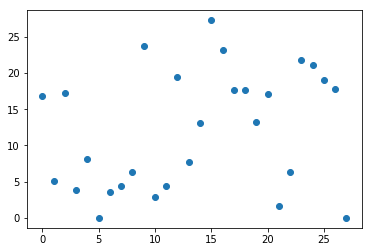

In [0]:
stock_quotes = stock_data[:,0]
scatter(days, stock_quotes)

How does our old model do?

In [0]:
days = np.array(days).reshape(-1, 1)
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.07693861844262018

Not bad, but can we do better?

In [0]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.score(stock_data[:,1:], stock_quotes)

0.7668480462095018

Yep - unsurprisingly, the other covariates (assets and liabilities) have info.

But, they do worse without the day data.

In [0]:
ols_stocks.fit(stock_data[:,2:], stock_quotes)
ols_stocks.score(stock_data[:,2:], stock_quotes)

0.5412874664104117

## Time series jargon

There's a lot of semi-standard language and tricks to talk about this sort of data. [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm) has an excellent guidebook, but here are some highlights:

### Moving average

Moving average aka rolling average aka running average.

Convert a series of data to a series of averages of continguous subsets:

In [0]:
stock_quotes_rolling = [sum(stock_quotes[i:i+3]) / 3
                        for i in range(len(stock_quotes - 2))]
stock_quotes_rolling

[13.078771349864313,
 8.764593879336497,
 9.742651310389425,
 3.984236575044408,
 3.8916238756225128,
 2.689374369376667,
 4.780930383268505,
 11.506949008785043,
 10.985126114182462,
 10.364143753110435,
 8.922785138727829,
 10.524577799212786,
 13.438162671018956,
 16.0394225576235,
 21.221804760068565,
 22.71209372959493,
 19.49760612877318,
 16.149522602189457,
 15.990764312276605,
 10.681682485673592,
 8.375517662789068,
 9.911619954719233,
 16.393009632195323,
 20.662521018635243,
 19.32160473763499,
 12.279213727226228,
 5.917541881836076,
 0.0033333333333333335]

Pandas has nice series related functions:

In [0]:
import pandas as pd
df = pd.DataFrame(stock_quotes)
df.rolling(3).mean()

,0
0,NaN
1,NaN
2,13.078771
3,8.764594
4,9.742651
5,3.984237
6,3.891624
7,2.689374
8,4.780930
9,11.506949


### Forecasting

Forecasting - at it's simplest, it just means "predict the future":

In [0]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.predict([[29, 0.5, 0.5]])

array([18.73136726])

One way to predict if you just have the series data is to use the prior observation. This can be pretty good (if you had to pick one feature to model the temperature for tomorrow, the temperature today is a good choice).

In [0]:
temperature = np.array([30 + random() * day
                        for day in np.array(range(365)).reshape(-1, 1)])
temperature_next = temperature[1:].reshape(-1, 1)
temperature_ols = LinearRegression()
temperature_ols.fit(temperature[:-1], temperature_next)
temperature_ols.score(temperature[:-1], temperature_next)

0.17446913276326537

But you can often make it better by considering more than one prior observation.

In [0]:
temperature_next_next = temperature[2:].reshape(-1, 1)
temperature_two_past = np.concatenate([temperature[:-2], temperature_next[:-1]],
                                      axis=1)
temperature_ols.fit(temperature_two_past, temperature_next_next)
temperature_ols.score(temperature_two_past, temperature_next_next)

0.2747118946497007

### Exponential smoothing

Exponential smoothing means using exponentially decreasing past weights to predict the future.

You could roll your own, but let's use Pandas.

In [0]:
temperature_df = pd.DataFrame(temperature)
temperature_df.ewm(halflife=7).mean()

,0
0,30.000000
1,30.330795
2,30.758706
3,31.311185
4,31.797121
5,32.263021
6,32.732330
7,32.445570
8,32.300969
9,32.659021


Halflife is among the parameters we can play with:

In [0]:
sse_1 = ((temperature_df - temperature_df.ewm(halflife=7).mean())**2).sum()
sse_2 = ((temperature_df - temperature_df.ewm(halflife=3).mean())**2).sum()
print(sse_1)
print(sse_2)

0    1.132953e+06
dtype: float64
0    915568.305799
dtype: float64


Note - the first error being higher doesn't mean it's necessarily *worse*. It's *smoother* as expected, and if that's what we care about - great!

### Seasonality

Seasonality - "day of week"-effects, and more. In a lot of real world data, certain time periods are systemically different, e.g. holidays for retailers, weekends for restaurants, seasons for weather.

Let's try to make some seasonal data - a store that sells more later in a week:

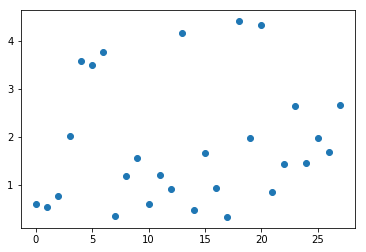

In [0]:
sales = np.array([random() + (day % 7) * random() for day in days])
scatter(days, sales)

How does linear regression do at fitting this?

In [0]:
sales_ols = LinearRegression()
sales_ols.fit(days, sales)
sales_ols.score(days, sales)

0.021736681200144714

That's not great - and the fix depends on the domain. Here, we know it'd be best to actually use "day of week" as a feature.

In [0]:
day_of_week = days % 7
sales_ols.fit(day_of_week, sales)
sales_ols.score(day_of_week, sales)

0.48752417794273933

Note that it's also important to have representative data across whatever seasonal feature(s) you use - don't predict retailers based only on Christmas, as that won't generalize well.

## Recurrent Neural Networks

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

### RNN/LSTM Sentiment Classification with Keras

In [0]:
%%time
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 115s 5ms/step - loss: 0.4657 - acc: 0.7780 - val_loss: 0.4166 - val_acc: 0.8138
Epoch 2/15
25000/25000 [==============================] - 116s 5ms/step - loss: 0.3092 - acc: 0.8732 - val_loss: 0.4393 - val_acc: 0.8043
Epoch 3/15
25000/25000 [==============================] - 115s 5ms/step - loss: 0.2261 - acc: 0.9112 - val_loss: 0.4223 - val_acc: 0.8328
Epoch 4/15
25000/25000 [==============================] - 114s 5ms/step - loss: 0.1581 - acc: 0.9416 - val_loss: 0.4438 - val_acc: 0.8206
Epoch 5/15
25000/25000 [==============================] - 114s 5ms/step - loss: 0.1095 - acc: 0.9615 - val_loss: 0.6014 - val_acc: 0.8252
Epoch 6/15
25000/25000 [==============================] - 114s 5ms/step - loss: 0.0866 - acc:

### RNN Text generation with NumPy

What else can we do with RNN? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. We'll pull some news stories using [newspaper](https://github.com/codelucas/newspaper/).

#### Initialization

In [0]:
!pip install newspaper3k

     |████████████████████████████████| 215kB 44.7MB/s 
     |████████████████████████████████| 7.4MB 48.8MB/s 
     |████████████████████████████████| 51kB 22.6MB/s 
     |████████████████████████████████| 194kB 49.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Stored in directory: /root/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
Successfully built jieba3k feedfinder2 tinysegmenter feedparser


In [0]:
import newspaper

In [0]:
ap = newspaper.build('https://www.apnews.com')
len(ap.articles)

123

In [0]:
article_text = ''

for article in ap.articles:
  try:
    article.download()
    article.parse()
    article_text += '\n\n' + article.text
  except:
    print('Failed: ' + article.url)
  
article_text = article_text.split('\n\n')[1]
print(article_text)

Failed: https://www.havasunews.com/news/gov-doug-ducey-signs-legislation-making-lemonade-the-state-drink/article_cc098972-7613-11e9-9c1a-7b09f5d55954.html
Failed: https://www.wiscnews.com/news/local/crime-and-courts/emmy-award-winner-named-as-beaver-dam-alumni-of-the/article_c22d881c-ba5e-502d-b318-b32e5d0e0062.html
Failed: https://www.postbulletin.com/realestate/news/building-a-better-bridge-to-survive-tsunamis/article_cbe10a10-6bbd-58fa-b743-e5db5618c49e.html
Failed: https://www.aikenstandard.com/news/masters-live-tiger-now-the-leader-by/article_78abc3a4-5eac-11e9-9b82-33b5238adfb0.html
Failed: https://www.aikenstandard.com/news/one-more-roar-woods-wins-fifth-masters-title/article_1b9637ca-5ee4-11e9-ba50-7f3a13d0d729.html
Failed: https://www.aikenstandard.com/news/mickelson-has-exceptional-back-nine-and-finishes-just-one-shot/article_b5857cb2-5ca8-11e9-9ef2-f77b3e6feb65.html
Failed: https://www.havasunews.com/news/ice-raids-occur-in-flagstaff-and-sedona/article_9c0dc0a3-292e-5853-b05

In [0]:
# Based on "The Unreasonable Effectiveness of RNN" implementation
import numpy as np

chars = list(set(article_text)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(article_text)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)

unique characters :  30
txt_data_size :  295


In [0]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in article_text] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'’': 0, 'k': 1, 'z': 2, 'y': 3, ' ': 4, 'b': 5, 'g': 6, 'A': 7, 'v': 8, 'f': 9, 't': 10, 's': 11, '-': 12, 'd': 13, 'n': 14, 'e': 15, 'i': 16, '.': 17, 'w': 18, ',': 19, 'l': 20, 'r': 21, 'a': 22, 'c': 23, 'm': 24, 'o': 25, 'h': 26, 'p': 27, 'u': 28, 'E': 29}
----------------------------------------------------
{0: '’', 1: 'k', 2: 'z', 3: 'y', 4: ' ', 5: 'b', 6: 'g', 7: 'A', 8: 'v', 9: 'f', 10: 't', 11: 's', 12: '-', 13: 'd', 14: 'n', 15: 'e', 16: 'i', 17: '.', 18: 'w', 19: ',', 20: 'l', 21: 'r', 22: 'a', 23: 'c', 24: 'm', 25: 'o', 26: 'h', 27: 'p', 28: 'u', 29: 'E'}
----------------------------------------------------
[7, 11, 4, 23, 25, 14, 23, 15, 21, 14, 4, 6, 21, 25, 18, 11, 4, 25, 8, 15, 21, 4, 26, 28, 24, 22, 14, 12, 16, 14, 13, 28, 23, 15, 13, 4, 23, 20, 16, 24, 22, 10, 15, 4, 23, 26, 22, 14, 6, 15, 19, 4, 24, 22, 14, 3, 4, 11, 23, 16, 15, 14, 10, 16, 11, 10, 11, 4, 22, 21, 15, 4, 20, 25, 25, 1, 16, 14, 6, 4, 5, 22, 23, 1, 4, 10, 26, 21, 25, 28, 6, 26, 4, 29, 22, 21, 10, 26, 0,

In [0]:
# hyperparameters

iteration = 1000
sequence_length = 40
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
hidden_size = 500  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

#### Forward propagation

In [0]:
def forwardprop(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars. 
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
 
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code

#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)        

    return loss, ps, hs, xs

#### Backward propagation

In [0]:
def backprop(ps, inputs, hs, xs):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

#### Training

In [0]:
%%time

data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 

for i in range(2 * iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch] for ch in article_text[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch] for ch in article_text[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(article_text) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress

iter 0, loss: 580.197493
iter 100, loss: 38.208660
iter 200, loss: 35.180307
iter 300, loss: 34.579091
iter 400, loss: 34.553002
iter 500, loss: 32.609181
iter 600, loss: 33.354920
iter 700, loss: 32.871969
iter 800, loss: 32.413651
iter 900, loss: 31.558351
iter 1000, loss: 30.997846
iter 1100, loss: 31.811958
iter 1200, loss: 31.966734
iter 1300, loss: 31.503976
iter 1400, loss: 31.846165
iter 1500, loss: 32.090695
iter 1600, loss: 31.714488
iter 1700, loss: 31.338045
iter 1800, loss: 30.339468
iter 1900, loss: 29.448545
CPU times: user 14min 49s, sys: 7min 54s, total: 22min 44s
Wall time: 11min 30s


#### Prediction

In [0]:
def predict(test_char, length):
    x = np.zeros((num_chars, 1)) 
    x[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, x) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = test_char + ''.join(int_to_char[i] for i in ixes)
    print ('----\n %s \n----' % (txt, ))

In [0]:
predict('A', 50)

----
 As contasirasanhpalet,egu  he eu hac  h    tocrcan  
----


Well... that's *vaguely* language-looking. Can you do better?

# Assignment

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [0]:
# TODO - Words, words, mere words, no matter from the heart.

# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN